In [1]:
import numpy as np
import cv2 as cv
import math
import matplotlib.pyplot as plt
import random
from skimage.transform import AffineTransform
from sklearn.linear_model import LinearRegression
import warnings

from scipy.spatial import distance
warnings.filterwarnings('ignore')

## Loading Images and declaring Functions

In [2]:
#load images that we want to stitch
left_img = cv.imread('../Image Stitching/sample_images/leftImage.png')
left_img = cv.cvtColor(left_img,cv.COLOR_BGR2RGB)
right_img = cv.imread('../Image Stitching/sample_images/rightImage.png')
right_img = cv.cvtColor(right_img,cv.COLOR_BGR2RGB)

In [3]:
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img)


def Corner_Harris(img, blocksize, ksize, K, threshold = 0.01):
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv.cornerHarris(gray, blockSize=blocksize, ksize=ksize, k=K)

    img[dst>threshold*dst.max()] = [255,0,0]

    display_img(img)

    return dst


def Convert_To_Keypoints(points, trs = 0.01):


    kps = np.argwhere(points > trs * points.max())
    kps = [cv.KeyPoint(float(pt[1]), float(pt[0]), 13) for pt in kps]


    return kps

def euclidian_dist (ds_left, ds_right):

    dst = np.zeros((len(ds_left), len(ds_right)))
    for i in range (len(ds_left)):
        for j in range (len(ds_right)):
            #Normalizing descriptors by dividing by each norm
            ds_left_norm = ds_left[i] / np.linalg.norm(ds_left[i])
            ds_right_norm = ds_right[j] / np.linalg.norm(ds_right[j])
            l2_distance = np.linalg.norm(ds_left_norm - ds_right_norm)
            dst[i][j] = l2_distance

    return dst

#Function Generating random pairs of matches
def gen_random_match(matches):
    matches_int= np.random.randint(len(matches),size=3)
    while len(matches_int) != len(np.unique(matches_int)):
            matches_int = np.random.randint(len(matches), size=3)

    return matches_int


### CORNER HARRIS

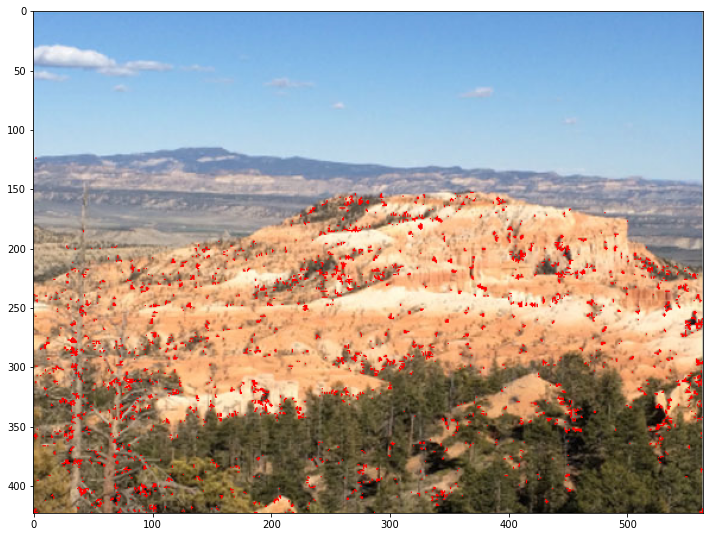

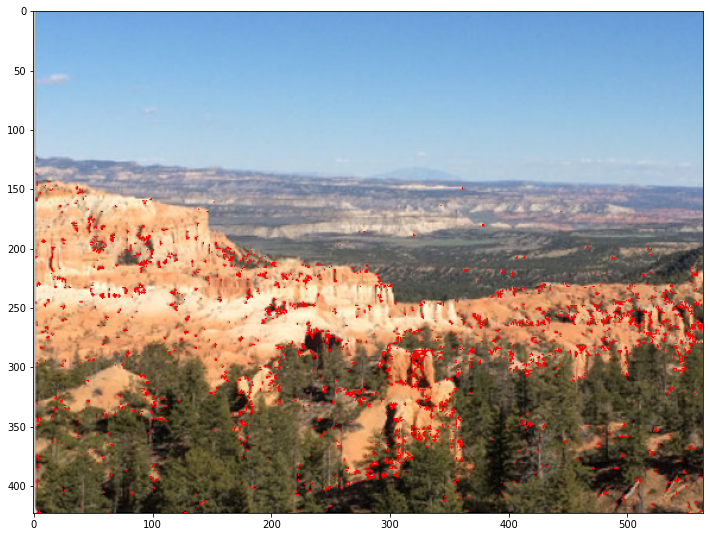

In [4]:
# Set the parameters for the Corner Harris
blocksize = 2
ksize = 3
K = 0.04
#Sent the left image to get back the corner points
left_harris = Corner_Harris(left_img,blocksize, ksize, K)
#sent right image
right_harris = Corner_Harris(right_img,blocksize, ksize, K)

In [5]:
# Convert and trehshold the keypoints from harris to use later for sift
keypoints_left = Convert_To_Keypoints(left_harris)
keypoints_right = Convert_To_Keypoints(right_harris)

### Sift Descriptors

In [6]:
sift = cv.SIFT_create()

keypoints_left, ds_left = sift.compute(left_img, keypoints_left)
keypoints_right, ds_right = sift.compute(right_img, keypoints_right)

## Calculating Euclidian distance of the Descriptors

In [7]:
distance = []
distance = euclidian_dist(ds_left, ds_right)

In [8]:
# I had nan values cause from the normalization so i use this high value so i can find the min values
distance[np.isnan(distance)] = 10

In [9]:
# Minimum distance calculated
distance.min()

0.06445031613111496

In [10]:
# We pick the best matches with Distance < 0.09
best_matches = np.where(distance < 0.09)

In [11]:
listOfCoordinates= list(zip(best_matches[0], best_matches[1]))

#Here we filter the listof coordinates to get only the best unique pairs
flag = 1
match_cord = []
for cord in listOfCoordinates:
    for i in range(len(match_cord)):
        if (cord[0] != match_cord[i][0] and cord[1] != match_cord[i][1] ):
            flag = 1
        else:
            flag = 0

    if flag == 1:
        match_cord.append(cord)

In [12]:
# We take the filtered coordinates and we convert it with Dmatch to memory list
match_cord_D = []
for i in range(len(match_cord)):
    match_cord_D.append( cv.DMatch(match_cord[i][0], match_cord[i][1], distance[match_cord[i][0]][match_cord[i][1]]))


In [13]:
#Number of selected matches
len(match_cord_D)


379

In [14]:
# We draw the best matches
sift_matches = cv.drawMatches(left_img,keypoints_left,right_img,keypoints_right,match_cord_D,None, flags=2)

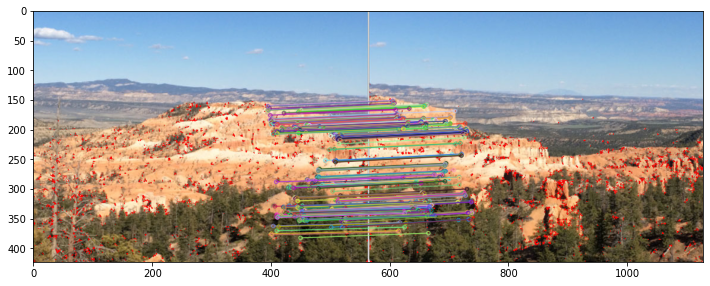

In [15]:
# Picture drawn with the best selected Matches
display_img(sift_matches)


## Ransac

In [16]:
# Here we go from memory to pixels so we can then proceed with Ransac
match_left = []
match_right= []
for kp in match_cord:
    left_cord  = keypoints_left[kp[0]].pt
    right_cord = keypoints_right[kp[1]].pt
    match_left.append((left_cord))
    match_right.append((right_cord))

In [17]:
def fit_line(X,x_target,y_target):
    X = np.array(X)
    x_target = np.asarray(x_target).reshape(-1,1)
    y_target = np.asarray(y_target).reshape(-1,1)

    #Fit first line
    reg1 = LinearRegression().fit(X, x_target)
    a1, b1, c1 = reg1.coef_[0][0], reg1.coef_[0][1], reg1.intercept_[0]


    #Fit second Line
    reg2 = LinearRegression().fit(X, y_target)
    a2, b2, c2 = reg2.coef_[0][0], reg2.coef_[0][1], reg2.intercept_[0]


    return a1,b1,c1,a2,b2,c2

In [43]:
def Ransac (L_pixels,R_pixels, tolerance=1, ts=0.9, max_iter=1000):

    condition = True
    iter = 0
    while condition == True:
        random_matches = gen_random_match(L_pixels)

        X = []
        x_target = []
        y_target = []
        for pixel in random_matches:
            X.append(L_pixels[pixel])
            x_target.append(R_pixels[pixel][0])
            y_target.append(R_pixels[pixel][1])

        a1,b1,c1,a2,b2,c2 = fit_line(X,x_target,y_target)

        inliers = []
        outliers = []
        sse = []
        for pixel in range(len(L_pixels)):
            if pixel not in random_matches:
                x_pi = L_pixels[pixel][0]
                y_pi = L_pixels[pixel][1]
                x_pi_target = R_pixels[pixel][0]
                y_pi_target = R_pixels[pixel][1]

                dist1 = abs(x_pi_target - a1*x_pi - b1*y_pi - c1)
                dist2 = abs(y_pi_target - a2*x_pi - b2*y_pi - c2)
                if dist1 <= tolerance and dist2 <= tolerance:
                    inliers.append(pixel)
                    sse.append(dist1)
                    sse.append(dist2)

                else:
                    outliers.append(pixel)
        iter = iter + 1
        #print(iter)
        condition = len(inliers)/len(L_pixels) <= ts and iter <= max_iter

    #Now we need to fit regression only in the inliers to get the best transformation
    X = []
    x_target = []
    y_target = []
    print(f'Number of Inliers: {len(inliers)}')
    print(f'Number of Outliers: {len(outliers)}')
    for pixel in inliers:
        X.append(L_pixels[pixel])
        x_target.append(R_pixels[pixel][0])
        y_target.append(R_pixels[pixel][1])

    a1,b1,c1,a2,b2,c2 = fit_line(X,x_target,y_target)

    #print(f'Average Residuals of inliers for fit 1: {(res1/len(inliers))*100:.2f}'+'%')
    #print(f'Average Residuals of inliers for fit 2: {(res2/len(inliers))*100:.2f}'+'%')



    return a1,b1,c1,a2,b2,c2,inliers,sse

## Image Stitching and Affine Transformation

Number of Inliers: 148
Number of Outliers: 228


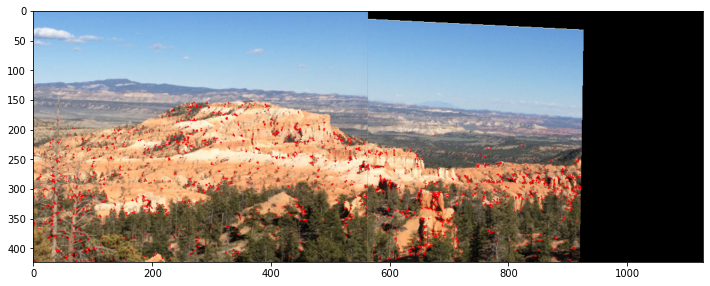

In [45]:
a1, b1, c1, a2, b2, c2, inliers, sse= Ransac(match_left, match_right, 1, ts=0.9)
#Build our affine Matrix
affine_TF = np.array([[a1, b1, c1], [a2, b2, c2], [0.0, 0.0, 1.0]])
stitched_img = cv.warpPerspective(right_img,affine_TF,((left_img.shape[1] + right_img.shape[1]), left_img.shape[0]),flags=cv.WARP_INVERSE_MAP) #wraped image



stitched_img[0:left_img.shape[0], 0:left_img.shape[1]] = left_img #stitched image
display_img(stitched_img)



In [36]:
in_matches = []
for pixels in inliers:
    in_matches.append(match_cord_D[pixels])

In [37]:
sift_matches_in = cv.drawMatches(left_img,keypoints_left,right_img,keypoints_right,in_matches,None, flags=2)

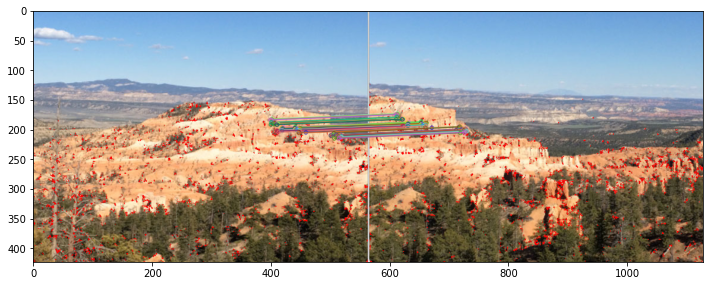

In [53]:
display_img(sift_matches_in)


In [52]:
print(f'Sum of least squares error: {sum(np.square(sse)/len(sse))}')

Sum of least squares error: 0.2191973019774921
